In [965]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
#import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

#### Admissions table

In [966]:
ADMISSIONS = pd.read_csv('ADMISSIONS.csv')

In [967]:
print(ADMISSIONS.info())
print(PATIENTS.info())
print(DIAGNOSES_ICD.info())
print(ICUSTAYS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [968]:
print('Dataset has {} number of unique admission events.'.format(ADMISSIONS['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(ADMISSIONS['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [969]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


### Calculate length of stay 
#### ADMISSIONS.csv

In [970]:
ADMISSIONS['ADMITTIME'] = pd.to_datetime(ADMISSIONS['ADMITTIME'])
ADMISSIONS['DISCHTIME'] = pd.to_datetime(ADMISSIONS['DISCHTIME'])
ADMISSIONS['LOS'] = (ADMISSIONS['DISCHTIME'] - ADMISSIONS['ADMITTIME']).dt.total_seconds()/86400

In [971]:
ADMISSIONS[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [972]:
ADMISSIONS['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [973]:
ADMISSIONS = ADMISSIONS[ADMISSIONS['LOS'] > 0]

In [974]:
ADMISSIONS['LOS'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

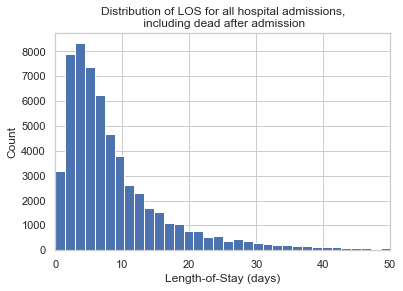

In [975]:
sns.set(style="whitegrid")
plt.hist(ADMISSIONS['LOS'], bins=200)
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions,\n including dead after admission')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

#### Now consider who died after admission


In [976]:
ADMISSIONS['DECEASED'] = ADMISSIONS['DEATHTIME'].notnull().map({True:1, False:0})

In [977]:
ADMISSIONS.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS,DECEASED
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.144444,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6.768056,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,6.988889,0
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,2.686806,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.364583,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,5.013889,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1,7.647917,1


In [978]:
print("{} of {} patients died in the hospital".format(ADMISSIONS['DECEASED'].sum(), ADMISSIONS['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


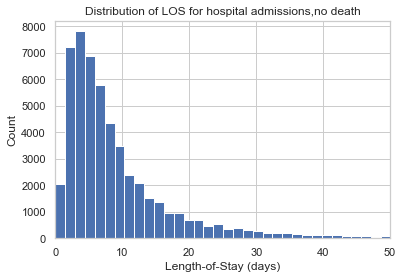

In [979]:
sns.set(style="whitegrid")
plt.hist(ADMISSIONS['LOS'].loc[ADMISSIONS['DECEASED'] == 0], bins=200)
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions,no death')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

#### Diagnosis_ICD.csv

In [980]:
DIAGNOSES_ICD = pd.read_csv('DIAGNOSES_ICD.csv')

In [981]:
DIAGNOSES_ICD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [982]:
print('There are {} unique ICD9 codes in this dataset.'.format(DIAGNOSES_ICD['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [983]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [984]:
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['ICD9_CODE']
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'][~DIAGNOSES_ICD['recode'].str.contains("[a-zA-Z]").fillna(False)]
DIAGNOSES_ICD['recode'].fillna(value='999', inplace=True)
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'].str.slice(start=0, stop=3, step=1)
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'].astype(int)

In [985]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [986]:
icd9_cat_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), (390, 460), (460, 520), 
                   (520, 580), (580, 630), (630, 680), (680, 710),(710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

In [987]:
len(icd9_cat_ranges)

18

In [988]:
diag_cat_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',4: 'mental', 5: 'nervous', 
             6: 'circulatory', 7: 'respiratory',8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 
             11: 'skin', 12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc', 16: 'injury', 17: 'misc'}

In [989]:
for i, cat_range in enumerate(icd9_cat_ranges):
    DIAGNOSES_ICD['recode'] = np.where(DIAGNOSES_ICD['recode'].between(cat_range[0],cat_range[1]), 
                                                            i, DIAGNOSES_ICD['recode'])
    
# Convert integer to category name using diag_dict
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode']
DIAGNOSES_ICD['category'] = DIAGNOSES_ICD['recode'].replace(diag_cat_dict)

In [990]:
DIAGNOSES_ICD

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,category
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory
...,...,...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280,1,neoplasms
651043,639799,97503,188195,3.0,V5869,16,injury
651044,639800,97503,188195,4.0,V1279,16,injury
651045,639801,97503,188195,5.0,5275,8,digestive


In [991]:
hadm_total = DIAGNOSES_ICD.groupby('HADM_ID')['category'].apply(list).reset_index()
hadm_total.head()

,HADM_ID,category
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [992]:
hadm_sep = pd.get_dummies(hadm_total['category'].apply(pd.Series).stack()).sum(level=0)
hadm_sep.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [993]:
hadm_sep = hadm_sep.join(hadm_total['HADM_ID'], how="outer")
hadm_sep.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [994]:
ADMISSIONS = ADMISSIONS.merge(hadm_sep, how='inner', on='HADM_ID')

In [995]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,4,1,0,0,0,1,0,0,0,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,0,0,0,0,1,0,0,0,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,3,0,0,0,1,1,0,1,0,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0,0,0,0,0,0,0,0,0,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0,0,0,0,0,0,0,0,0,0


In [996]:
list(diag_cat_dict.values())

['infectious',
 'neoplasms',
 'endocrine',
 'blood',
 'mental',
 'nervous',
 'circulatory',
 'respiratory',
 'digestive',
 'genitourinary',
 'pregnancy',
 'skin',
 'muscular',
 'congenital',
 'prenatal',
 'misc',
 'injury',
 'misc']

In [997]:
results = []
for i in list(diag_cat_dict.values()):
    results.append(ADMISSIONS[[i, 'LOS']].groupby(i).median().reset_index().values[1][1])

results

[8.81875,
 7.8625,
 6.71875,
 7.803472222222222,
 6.958333333333334,
 7.215277777777778,
 6.375,
 7.299305555555556,
 7.076388888888889,
 7.885416666666667,
 5.465625000000001,
 9.930555555555555,
 7.089236111111111,
 7.258680555555555,
 5.877777777777778,
 7.944444444444445,
 6.519444444444445,
 7.944444444444445]

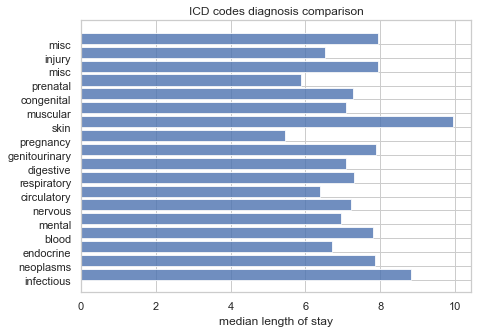

In [998]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(list(diag_cat_dict.values()))
ax.set_xlabel('median length of stay')
ax.set_title('ICD codes diagnosis comparison')
plt.show()

#### ICUSTAYS table

In [999]:
ICUSTAYS = pd.read_csv('ICUSTAYS.csv')

In [1000]:
ICUSTAYS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [1001]:
print('Dataset has {} number of unique icu admissions.'.format(ICUSTAYS['HADM_ID'].nunique()))

Dataset has 57786 number of unique icu admissions.


In [1002]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts().index.tolist()

['MICU', 'CSRU', 'SICU', 'NICU', 'CCU', 'TSICU']

In [1003]:
ICUSTAYS['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [1004]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts().index.tolist()

['ICU', 'NICU']

In [1005]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [1006]:
ICUSTAYS['CAT'] = ICUSTAYS['FIRST_CAREUNIT']
ICUSTAYS_CAT_Lst = ICUSTAYS.groupby('HADM_ID')['CAT'].apply(list).reset_index()
ICUSTAYS_CAT_Lst.head()

,HADM_ID,CAT
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [1007]:
ICU_type_split = pd.get_dummies(ICUSTAYS_CAT_Lst['CAT'].apply(pd.Series).stack()).sum(level=0)
ICU_type_split[ICU_type_split >= 1] = 1

In [1008]:
ICU_type_split = ICU_type_split.join(ICUSTAYS_CAT_Lst['HADM_ID'], how="outer")
ICU_type_split.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [1009]:
ICU_type_split.ICU.sum()

49794

In [1010]:
ICU_type_split.NICU.sum()

7992

In [1011]:
ADMISSIONS = ADMISSIONS.merge(ICU_type_split, how='outer', on='HADM_ID')

In [1012]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1013]:
ADMISSIONS.ICU.value_counts(dropna=False)

1.0    49794
0.0     7992
NaN     1176
Name: ICU, dtype: int64

In [1014]:
ADMISSIONS.NICU.value_counts(dropna=False)

0.0    49794
1.0     7992
NaN     1176
Name: NICU, dtype: int64

In [1015]:
ADMISSIONS['ICU'].fillna(value=0, inplace=True)
ADMISSIONS['NICU'].fillna(value=0, inplace=True)

In [1016]:
ADMISSIONS.ICU.value_counts(dropna=False)

1.0    49794
0.0     9168
Name: ICU, dtype: int64

In [1017]:
ADMISSIONS.NICU.value_counts(dropna=False)

0.0    50970
1.0     7992
Name: NICU, dtype: int64

In [1018]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Patients table

In [1019]:
PATIENTS = pd.read_csv('PATIENTS.csv')

In [1020]:
PATIENTS.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [1021]:
PATIENTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
ROW_ID         46520 non-null int64
SUBJECT_ID     46520 non-null int64
GENDER         46520 non-null object
DOB            46520 non-null object
DOD            15759 non-null object
DOD_HOSP       9974 non-null object
DOD_SSN        13378 non-null object
EXPIRE_FLAG    46520 non-null int64
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [1022]:
PATIENTS['DOB'] = pd.to_datetime(PATIENTS['DOB'])

In [1023]:
PATIENTS.drop(columns=['ROW_ID','DOD_HOSP','DOD_SSN','EXPIRE_FLAG','DOD'], inplace=True)
#PATIENTS = PATIENTS[['SUBJECT_ID', 'DOB', 'GENDER']]

In [1024]:
PATIENTS.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [1025]:
ADMISSIONS = ADMISSIONS.merge(PATIENTS, how='inner', on='SUBJECT_ID')

In [1026]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU,GENDER,DOB
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,F,2131-05-07
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2082-07-17
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,M,2082-07-17
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2100-05-31
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2101-11-21


#### Calculate age for each patient using DOB from new admission table.

In [1027]:
AGE = ADMISSIONS[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
AGE.columns = ['SUBJECT_ID', 'ADMITTIME_earliest']
AGE.head()

,SUBJECT_ID,ADMITTIME_earliest
0,2.0,2138-07-17 19:04:00
1,3.0,2101-10-20 19:08:00
2,4.0,2191-03-16 00:28:00
3,5.0,2103-02-02 04:31:00
4,6.0,2175-05-30 07:15:00


In [1028]:
ADMISSIONS = ADMISSIONS.merge(AGE, how='outer', on='SUBJECT_ID')

In [1029]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU,GENDER,DOB,ADMITTIME_earliest
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,F,2131-05-07,2196-04-09 12:26:00
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2082-07-17,2153-09-03 07:15:00
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,M,2082-07-17,2153-09-03 07:15:00
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2100-05-31,2139-06-06 16:14:00
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2101-11-21,2160-11-02 02:06:00


In [1030]:
ADMISSIONS['ADMITTIME_earliest'] = pd.to_datetime(ADMISSIONS['ADMITTIME_earliest'])

In [1031]:
ADMISSIONS['DOB'] = pd.to_datetime(ADMISSIONS['DOB'])

def change(x):
    return x.date()

ADMISSIONS['ADMITTIME_earliest'] = ADMISSIONS['ADMITTIME_earliest'].apply(change)


In [1032]:
#ADMISSIONS['age'] = ((ADMISSIONS['ADMITTIME_earliest'] - ADMISSIONS['DOB']).dt.days) // 365
ADMISSIONS['age'] = ADMISSIONS['ADMITTIME_earliest'].subtract(ADMISSIONS['DOB']).dt.days // 365

ADMISSIONS['age'] = np.where(ADMISSIONS['age'] < 0, 90, ADMISSIONS['age'])
ADMISSIONS['age'] = np.where(ADMISSIONS['age'] == -0, 0, ADMISSIONS['age'])

In [1033]:
print('There are {} null value in AGE in this dataset.'.format(ADMISSIONS['age'].isnull().sum()))

There are 0 null value in AGE in this dataset.


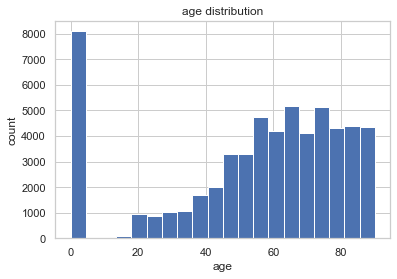

In [1034]:
plt.hist(ADMISSIONS['age'], bins=20)
plt.ylabel('count')
plt.xlabel('age')
plt.title('age distribution')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

In [1035]:
def plot(INPUT):
    results = ADMISSIONS[[INPUT, 'LOS']].groupby(INPUT).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[INPUT].values)

    fig, ax = plt.subplots(figsize=(7,4))
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(INPUT))
    plt.tight_layout()
    plt.show()

In [1040]:
def boxplot(INPUT):
    results = ADMISSIONS[[INPUT, 'LOS']].groupby(INPUT).median().reset_index()
    print(results)

    data = []
    for i in results[INPUT].values.tolist():
        data.append(ADMISSIONS['LOS'].loc[ADMISSIONS[INPUT]==i].values)
    print(data)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.boxplot(data, 0, '', vert=False)
    ax.set_xlim((0, 40))
    ax.set_yticklabels(results[INPUT].values.tolist())
    ax.set_xlabel('length of Stay')
    ax.tick_params(left=False, right=False) 
    ax.set_title('comparison of {}'.format(INPUT))
    
    plt.show()

   GENDER       LOS
0       0  6.509375
1       1  6.456944
[array([5.49652778, 6.76805556, 2.85694444, ..., 4.14583333, 0.6625    ,
       8.20347222]), array([ 1.14444444,  2.68680556, 10.17708333, ..., 10.79444444,
        2.74236111,  0.54861111])]


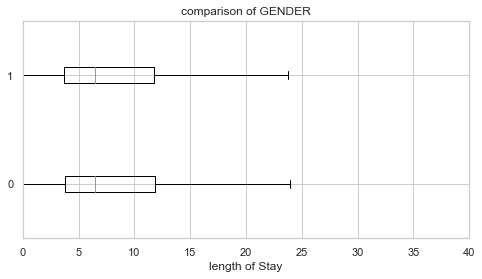

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [1041]:
boxplot('GENDER')
ADMISSIONS['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

  ADMISSION_TYPE       LOS
0       ELECTIVE  6.323958
1      EMERGENCY  6.905556
2        NEWBORN  4.097917
3         URGENT  8.114583
[array([ 5.49652778,  5.36458333, 19.19791667, ...,  0.32708333,
        4.14583333,  8.20347222]), array([1.14444444, 6.76805556, 2.85694444, ..., 0.6625    , 2.74236111,
       0.54861111]), array([2.68680556, 9.75416667, 4.14930556, ..., 3.89652778, 2.54027778,
       2.07777778]), array([ 5.01388889,  9.09375   ,  7.09166667, ...,  1.14930556,
        7.94236111, 11.90694444])]


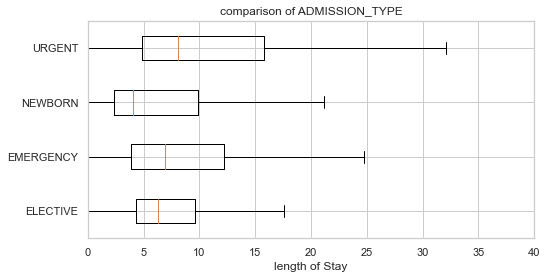

In [901]:
ADMISSIONS['ADMISSION_TYPE'].value_counts()
boxplot('ADMISSION_TYPE')

      MARITAL_STATUS       LOS
0           DIVORCED  7.226389
1       LIFE PARTNER  6.083333
2            MARRIED  6.943750
3          SEPARATED  7.384028
4             SINGLE  6.472569
5  UNKNOWN (DEFAULT)  6.524306
6            WIDOWED  7.081597
[array([10.17708333,  7.94305556,  0.52083333, ...,  7.09097222,
        5.97638889,  3.77013889]), array([ 3.11111111,  4.55277778,  6.08333333,  6.93194444,  7.00277778,
       10.45416667,  1.27916667, 14.80277778,  2.80763889, 11.76111111,
        5.18055556, 27.95138889,  5.86736111,  4.09652778,  6.75694444]), array([ 1.14444444,  5.49652778,  6.76805556, ..., 10.57291667,
        4.14583333,  8.20347222]), array([ 10.58819444,   3.91388889,   4.7875    ,   3.81527778,
         2.79444444,   3.81111111,   7.40763889,   4.97430556,
         8.48611111,   6.59375   ,  81.00555556,   2.525     ,
        16.65486111,   9.06041667,   7.29513889,  35.37986111,
        23.32361111,   3.59166667,   5.10277778,  21.00416667,
         4.91458333,

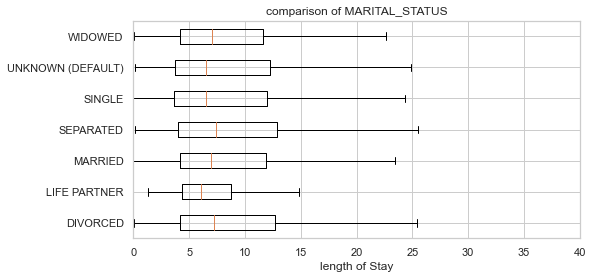

In [907]:
boxplot('MARITAL_STATUS')

    INSURANCE       LOS
0  Government  5.525694
1    Medicaid  6.176736
2    Medicare  7.151042
3     Private  5.689236
4    Self Pay  4.033333
[array([ 1.94305556, 24.48611111,  4.66180556, ...,  0.64236111,
        4.90208333,  4.57847222]), array([19.19791667, 15.15      ,  6.49166667, ...,  5.06458333,
        4.36319444,  2.68055556]), array([5.49652778, 6.76805556, 6.98888889, ..., 4.14583333, 0.6625    ,
       0.54861111]), array([ 1.14444444,  2.85694444,  3.53402778, ..., 10.57291667,
        2.74236111,  8.20347222]), array([3.50833333e+00, 4.98680556e+00, 1.01097222e+01, 4.02777778e-01,
       3.08472222e+00, 5.15277778e-01, 2.60902778e+00, 3.15972222e+00,
       1.90138889e+00, 5.28472222e-01, 7.15972222e-01, 2.42222222e+00,
       6.03333333e+00, 2.84444444e+00, 6.82083333e+00, 6.18888889e+00,
       1.64583333e+01, 4.10000000e+00, 1.40187500e+01, 3.15694444e+00,
       6.96527778e-01, 5.61527778e+00, 3.74652778e+00, 4.19791667e+00,
       6.20333333e+01, 6.51458333e+00, 

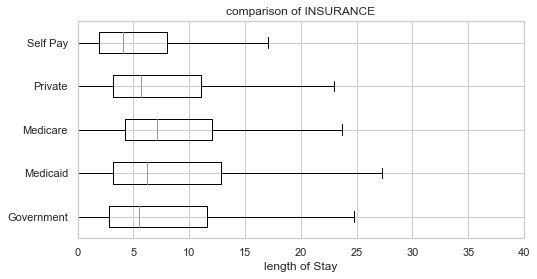

In [908]:
boxplot('INSURANCE')

In [897]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 44 columns):
ROW_ID                  58878 non-null float64
SUBJECT_ID              58878 non-null float64
HADM_ID                 58962 non-null int64
ADMITTIME               58878 non-null datetime64[ns]
DISCHTIME               58878 non-null datetime64[ns]
DEATHTIME               5774 non-null object
ADMISSION_TYPE          58878 non-null object
ADMISSION_LOCATION      58878 non-null object
DISCHARGE_LOCATION      58878 non-null object
INSURANCE               58878 non-null object
LANGUAGE                33606 non-null object
RELIGION                58426 non-null object
MARITAL_STATUS          48781 non-null object
ETHNICITY               58878 non-null object
EDREGTIME               30821 non-null object
EDOUTTIME               30821 non-null object
DIAGNOSIS               58853 non-null object
HOSPITAL_EXPIRE_FLAG    58878 non-null float64
HAS_CHARTEVENTS_DATA    58878 non-null float64